`March 25, 2022`

#### **MORE EXERCISE!**

**`There are no instructions for this exercise. Just apply what you have learned about data preprocessing and model building to the 'income' dataset. Two mandatory things to do are you have to give arguments about what you do in each step and interpret the results (as we usually do in the previous exercises).`**

**NB:** *Please explore and preprocess the data thoroughly as we may improve this notebook in the upcoming sessions.*

<hr>

### **Import Libraries**

In [46]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import fbeta_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')

### **Load Dataset**

In [3]:
df = pd.read_csv('income.csv')
df.head()

,age,work,final weight,education,education num,marital status,occupation,relationship,race,gender,capital gained,capital lost,hours per week,native country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### **Exploratory Data Analysis**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   work            32561 non-null  object
 2   final weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education num   32561 non-null  int64 
 5   marital status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital gained  32561 non-null  int64 
 11  capital lost    32561 non-null  int64 
 12  hours per week  32561 non-null  int64 
 13  native country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df['income'].value_counts(True)

 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64

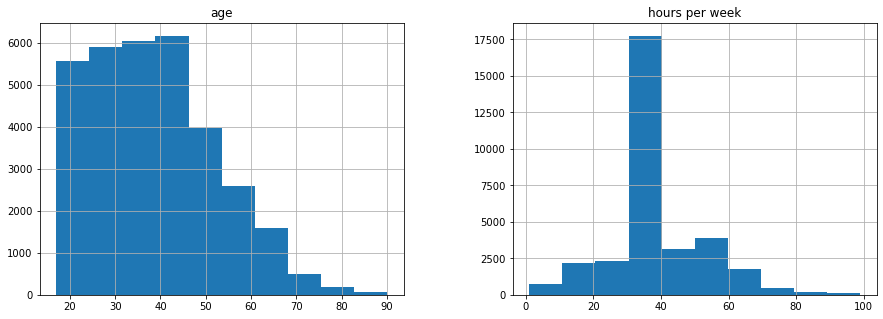

In [6]:
num_cols = ['age', 'hours per week']

df[num_cols].hist(figsize=(15, 5));

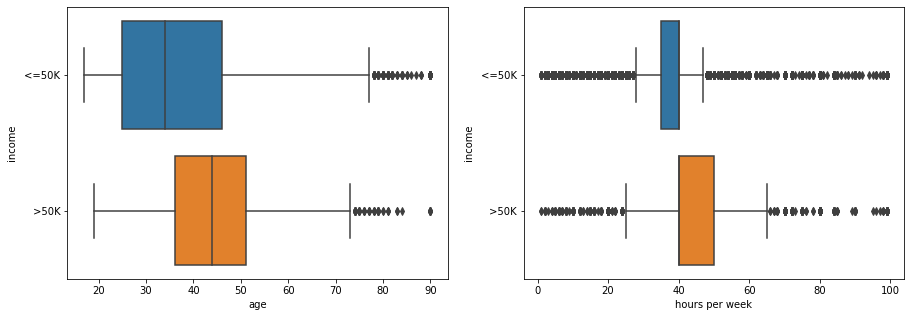

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

for ix, col in enumerate(num_cols):
    sns.boxplot(x=col, y='income', data=df, ax=ax[ix]);

In [8]:
df.groupby('income')['hours per week'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,24720.0,38.840210,12.318995,1.0,35.0,40.0,40.0,99.0
>50K,7841.0,45.473026,11.012971,1.0,40.0,40.0,50.0,99.0


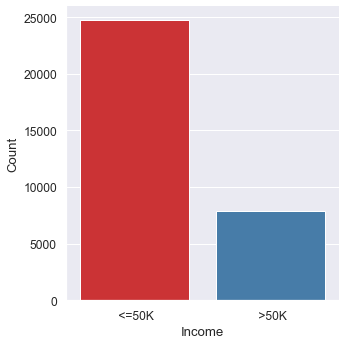

In [9]:
# Plot income proportion.
sns.set(style='darkgrid', font_scale = 1.1, palette='Set1')
ax = sns.catplot(x='income', data=df, kind='count', height=5)
plt.xlabel('Income')
plt.ylabel('Count');

`Gender`

In [10]:
# Income categories by gender.
gender_income = (df.groupby(['income'])['gender']
                     .value_counts(True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('gender'))

gender_income

,income,gender,percentage
1,<=50K,Female,38.802589
3,>50K,Female,15.036347
0,<=50K,Male,61.197411
2,>50K,Male,84.963653


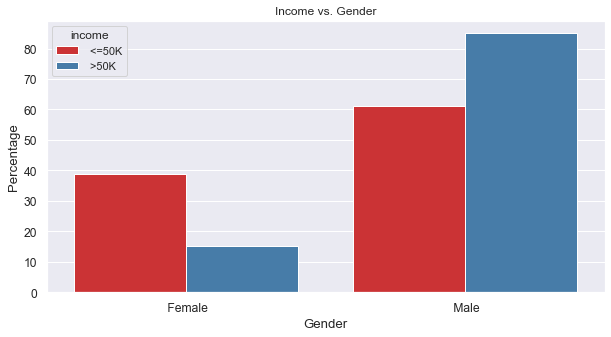

In [11]:
# Plot income vs gender.
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style='darkgrid', font_scale=1, palette='Set1',)
sns.barplot(x='gender', y='percentage', hue='income', data=gender_income)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Income vs. Gender');

`Race`

In [12]:
# Income categories by race.
race_income = (df.groupby(['income'])['race']
                .value_counts(True)
                .rename('percentage')
                .mul(100)
                .sort_values()
                .reset_index())

race_income

,income,race,percentage
0,>50K,Other,0.318837
1,>50K,Amer-Indian-Eskimo,0.459125
2,<=50K,Other,0.995146
3,<=50K,Amer-Indian-Eskimo,1.112460
4,<=50K,Asian-Pac-Islander,3.086570
5,>50K,Asian-Pac-Islander,3.519959
6,>50K,Black,4.935595
7,<=50K,Black,11.072006
8,<=50K,White,83.733819
9,>50K,White,90.766484


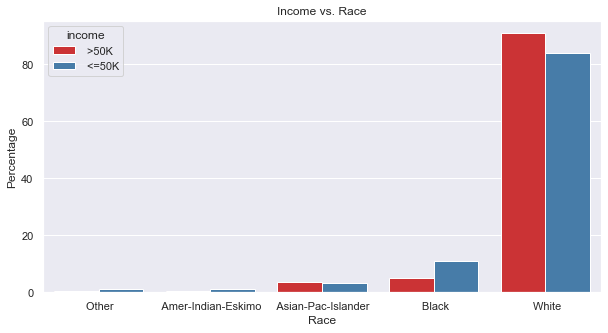

In [13]:
# Plot income vs race.
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style='darkgrid', font_scale=1, palette='Set1')
sns.barplot(x='race', y='percentage', hue='income', data=race_income)
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.title('Income vs. Race');

`Age`

In [14]:
# Create age_group column to categorize the range of age.
age_list = [df]

for age in age_list:
    age.loc[age['age'] < 30, 'age_group'] = 20
    age.loc[(age['age'] >= 30) & (age['age'] <= 39), 'age_group'] = 30
    age.loc[(age['age'] >= 40) & (age['age'] <= 49), 'age_group'] = 40
    age.loc[(age['age'] >= 50) & (age['age'] <= 59), 'age_group'] = 50
    age.loc[(age['age'] >= 60) & (age['age'] <= 69), 'age_group'] = 60
    age.loc[(age['age'] >= 70) & (age['age'] <= 79), 'age_group'] = 70
    age.loc[age['age'] >= 80, 'age_group'] = 80

In [15]:
# Change age_group type from float 64 to int64.
df['age_group'] = df['age_group'].astype(np.int64)
df.head()

,age,work,final weight,education,education num,marital status,occupation,relationship,race,gender,capital gained,capital lost,hours per week,native country,income,age_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,30
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,50
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,30
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,50
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,20


In [16]:
# Income categories by age_group.
age_income = (df.groupby(['income'])['age_group']
                .value_counts(True)
                .rename('percentage')
                .mul(100)
                .sort_values()
                .reset_index())

age_income

,income,age_group,percentage
0,>50K,80,0.204056
1,<=50K,80,0.424757
2,>50K,70,1.237087
3,<=50K,70,1.662621
4,<=50K,60,5.970874
5,>50K,20,6.517026
6,>50K,60,6.874123
7,<=50K,50,10.966828
8,<=50K,40,18.256472
9,>50K,50,21.770182


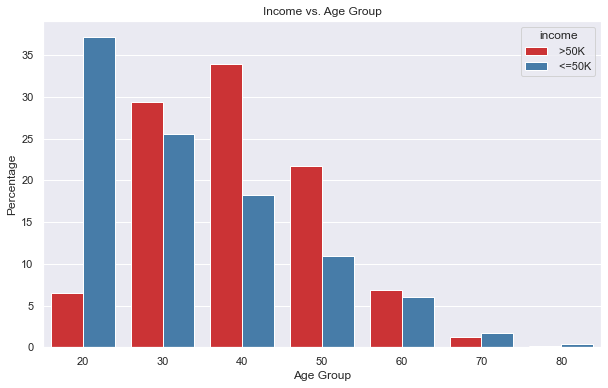

In [17]:
# Plot income vs age_group.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style='darkgrid', font_scale=1, palette='Set1')
sns.barplot(x='age_group', y='percentage', hue='income', data=age_income)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Income vs. Age Group');

`Relationship`

In [18]:
# Income categories by relationship.
relationship_income = (df.groupby(['income'])['relationship']
                .value_counts(True)
                .rename('percentage')
                .mul(100)
                .sort_values()
                .reset_index())

relationship_income

,income,relationship,percentage
0,>50K,Other-relative,0.471879
1,>50K,Own-child,0.854483
2,>50K,Unmarried,2.780258
3,<=50K,Wife,3.329288
4,<=50K,Other-relative,3.818770
5,>50K,Wife,9.501339
6,>50K,Not-in-family,10.916975
7,<=50K,Unmarried,13.058252
8,<=50K,Own-child,20.230583
9,<=50K,Husband,29.429612


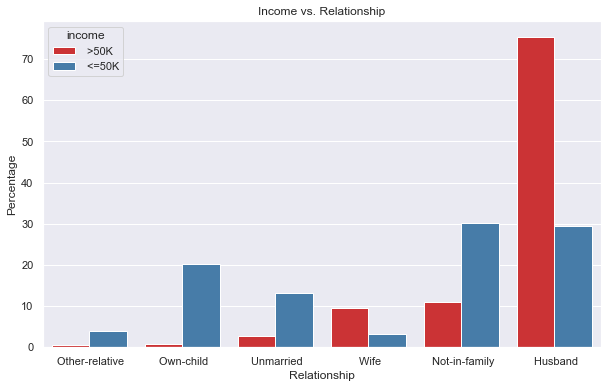

In [19]:
# Plot income vs relationship.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style='darkgrid', font_scale=1, palette='Set1')
sns.barplot(x='relationship', y='percentage', hue='income', data=relationship_income)
plt.xlabel('Relationship')
plt.ylabel('Percentage')
plt.title('Income vs. Relationship');

`Occupation`

In [20]:
# Income categories by occupation.
occupation_income = (df.groupby(['income'])['occupation']
                .value_counts(True)
                .rename('percentage')
                .mul(100)
                .sort_values()
                .reset_index())

occupation_income

,income,occupation,percentage
0,>50K,Priv-house-serv,0.012753
1,>50K,Armed-Forces,0.012753
2,<=50K,Armed-Forces,0.032362
3,<=50K,Priv-house-serv,0.598706
4,>50K,Handlers-cleaners,1.096799
5,>50K,Farming-fishing,1.466650
6,>50K,Other-service,1.747226
7,<=50K,Protective-serv,1.771845
8,>50K,?,2.435914
9,<=50K,Tech-support,2.609223


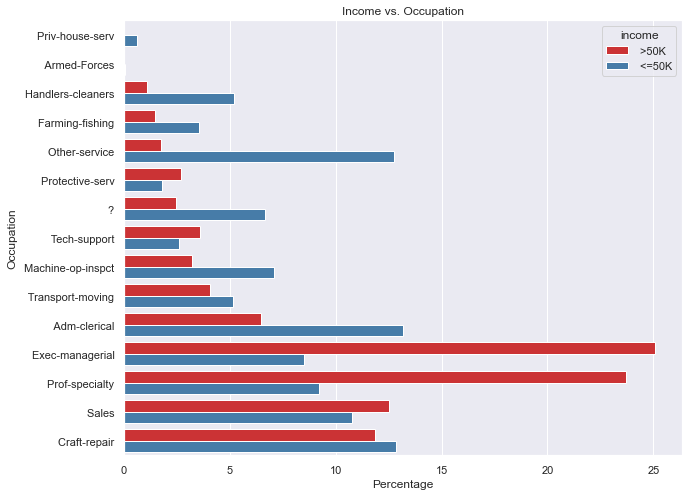

In [21]:
# Plot income vs age_group.
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(style='darkgrid', font_scale=1, palette='Set1')
sns.barplot(y='occupation', x='percentage', hue='income', data=occupation_income)
plt.ylabel('Occupation')
plt.xlabel('Percentage')
plt.title('Income vs. Occupation');

`Country`

In [22]:
df['native country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [23]:
# Modify native country column.
df['native country enc'] = df['native country'].apply(lambda x: 1 if x == ' United-States' else 0)

In [24]:
df['native country enc'].value_counts()

1    29170
0     3391
Name: native country enc, dtype: int64

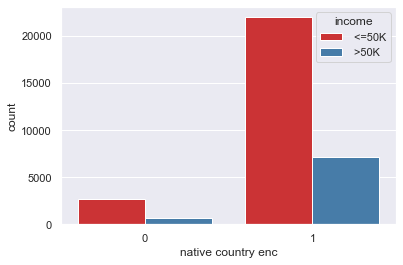

In [25]:
sns.countplot(x='native country enc', hue='income', data=df);

In [26]:
df[df['native country enc'] == 1]['income'].value_counts(True)

 <=50K    0.754165
 >50K     0.245835
Name: income, dtype: float64

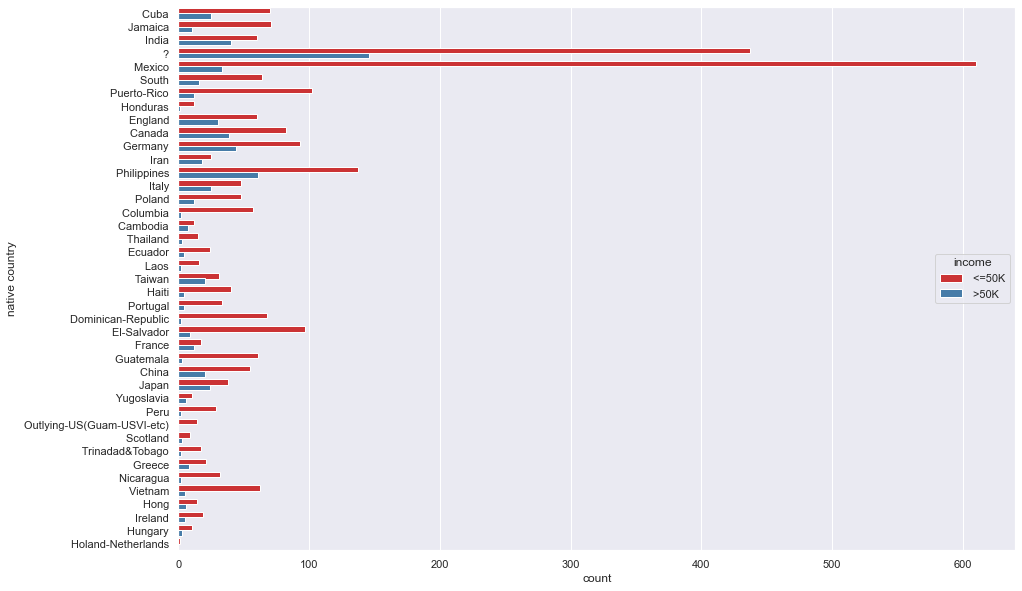

In [27]:
plt.figure(figsize=(15, 10))
sns.countplot(y='native country', hue='income', data=df[df['native country enc'] == 0]);

### **Data Cleaning & Preprocessing**

In [28]:
# The default of keep is 'first'. Thus will only count the first occurrence.
df[df.duplicated()].count()

age                   24
work                  24
final weight          24
education             24
education num         24
marital status        24
occupation            24
relationship          24
race                  24
gender                24
capital gained        24
capital lost          24
hours per week        24
native country        24
income                24
age_group             24
native country enc    24
dtype: int64

In [29]:
# Set keep = False to find the total row of duplicated data.
df[df.duplicated(keep=False)].count()

age                   47
work                  47
final weight          47
education             47
education num         47
marital status        47
occupation            47
relationship          47
race                  47
gender                47
capital gained        47
capital lost          47
hours per week        47
native country        47
income                47
age_group             47
native country enc    47
dtype: int64

In [30]:
df[df['work'] == '?'].sum()

age                   0.0
work                  0.0
final weight          0.0
education             0.0
education num         0.0
marital status        0.0
occupation            0.0
relationship          0.0
race                  0.0
gender                0.0
capital gained        0.0
capital lost          0.0
hours per week        0.0
native country        0.0
income                0.0
age_group             0.0
native country enc    0.0
dtype: float64

In [31]:
# Define X and y.
X = df.drop(columns=['income', 'native country', 'final weight', 'education', 'capital gained', 'capital lost', 'age_group'])
y = df['income']

In [32]:
# Split data.
X_train, X_test, y_train, y_test = train_test_split(
                                             X,
                                             y,
                                             test_size=0.2,
                                             random_state=42
)

In [33]:
X_train.head(3)

,age,work,education num,marital status,occupation,relationship,race,gender,hours per week,native country enc
5514,33,Local-gov,13,Never-married,Prof-specialty,Not-in-family,White,Female,50,1
19777,36,Private,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,1
10781,58,Self-emp-not-inc,5,Separated,Craft-repair,Not-in-family,White,Male,40,1


**Preprocessing Schemas**

- Missing values (?) ['work', 'occupation] --> Impute with mode.
- Categorical columns: work, marital status, occupation, relationship, race, gender --> onehotencoder
- Numerical columns scaling: age, hours per week --> RobustScaler
- Numerical columns: education num, native country enc --> No preprocessing needed.

In [34]:
# Prepare column transformers
num_cols = ['age', 'hours per week']
cat_cols = ['work', 'marital status', 'occupation', 'relationship', 'race', 'gender']
imputed_cat_cols = ['work', 'occupation']
ignore = ['education num', 'native country enc']

imputer_mode = SimpleImputer(missing_values='?', strategy='most_frequent')
ohe = OneHotEncoder(drop='first')
scaler = RobustScaler()
ignore_cols = FunctionTransformer() # Custom transformer that will do nothing.

# Pipeline
imputed_pipeline = Pipeline([
        ('imputer', imputer_mode),
        ('encoder', ohe)
])

transformer = ColumnTransformer([
        ('imputed pipeline', imputed_pipeline, imputed_cat_cols),
        ('encoder', ohe, cat_cols),
        ('scaling', scaler, num_cols),
        ('ignore', ignore_cols, ignore)
])

In [41]:
# Encode y_train & y_test
y_train = y_train.apply(lambda x: 1 if x == ' >50K' else 0)
y_test = y_test.apply(lambda x: 1 if x == ' >50K' else 0)

### **Model Training**

**Model Pipelines**

In [51]:
# Prepare training pipeline for each model.
logreg = LogisticRegression(random_state=42, max_iter=1000)
dt = DecisionTreeClassifier(random_state=42)

# Pipeline
logreg_pipeline = Pipeline([
        ('preprocessing', transformer),
        ('logreg', logreg)
])

dt_pipeline = Pipeline([
        ('preprocessing', transformer),
        ('dt', dt)
])


In [62]:
logreg_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('imputed pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values='?',
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['work', 'occupation']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['work', 'marital status',
                                                   'occupation', 'relationship',
                                                   'race',

In [53]:
# Train each model pipeline with CV
print('CV Results\n')
print('Logistic Regression')
print('Accuracy', cross_val_score(logreg_pipeline, X_train, y_train, scoring='accuracy', cv=5).mean())
print('Recall', cross_val_score(logreg_pipeline, X_train, y_train, scoring='recall', cv=5).mean())
print('Precision', cross_val_score(logreg_pipeline, X_train, y_train, scoring='precision', cv=5).mean())

print()
print('Decision Tree')
print('Accuracy', cross_val_score(dt_pipeline, X_train, y_train, scoring='accuracy', cv=5).mean())
print('Recall', cross_val_score(dt_pipeline, X_train, y_train, scoring='recall', cv=5).mean())
print('Precision', cross_val_score(dt_pipeline, X_train, y_train, scoring='precision', cv=5).mean())

CV Results

Logistic Regression
Accuracy 0.8352273803386948
Recall 0.5607655502392344
Precision 0.6957636331965801

Decision Tree
Accuracy 0.7882756590265851
Recall 0.5424242424242425
Precision 0.5623712650341653


`Interpretation`

Logistic Regression

1. Accuracy: Dari total prediksi yang dilakukan, 83% prediksi bernilai True Positive dan True Negative.
2. Recall: 56% dari total prediksi penduduk dengan gaji di atas $50K berhasil diprediksi dengan benar oleh model.
3. Precision: 69.5% dari total prediksi benar memiliki gaji di atas $50K.

In [54]:
logreg_pipeline.fit(X_train, y_train)
y_train_pred = logreg_pipeline.predict(X_train)

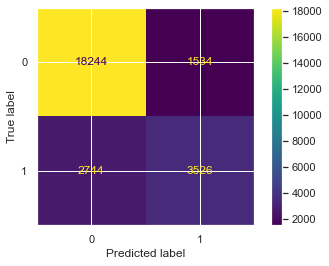

In [55]:
# Plot confusion matrix.
log_reg_confusion = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(log_reg_confusion).plot();

In [56]:
logreg_pipeline.score(X_test, y_test)

0.8331030247197911

In [57]:
logreg_pipeline.predict(X_test)

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

### **Hyperparameter Tuning with CV**

Hyperparameter: parameter yang mengatur bagaimana model akan belajar.

In [59]:
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [60]:
# Initialize a decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Decision tree params grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [100, 300, 500]
}

# Decision tree params grid search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [100, 300, 500]
}

# Initialize a grid search tuner
grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        return_train_score=True,
        n_jobs=-1
)

random_search = RandomizedSearchCV(
        estimator=dt,
        param_distributions=param_dist,
        scoring='accuracy',
        cv=5,
        return_train_score=True,
        n_jobs=-1,
        random_state=42
)

In [61]:
grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'min_samples_split': [100, 300, 500]},
             return_train_score=True, scoring='accuracy')

In [65]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
17,0.301823,0.036586,0.002793,0.000399,entropy,20,500,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.834549,0.832630,...,0.833807,0.001065,1,0.839380,0.837988,0.838756,0.838812,0.839676,0.838922,0.000581
16,0.453732,0.049516,0.004588,0.002055,entropy,20,300,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.831862,0.834165,...,0.833692,0.001170,2,0.842643,0.841060,0.842307,0.841019,0.842363,0.841878,0.000695
7,0.593511,0.054286,0.004390,0.001623,gini,20,300,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.832438,0.835125,...,0.833154,0.002624,3,0.843123,0.839428,0.840580,0.840012,0.841067,0.840842,0.001266
8,0.391910,0.030790,0.012270,0.014704,gini,20,500,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.833013,0.834933,...,0.832079,0.002703,4,0.837460,0.837029,0.836645,0.836365,0.838716,0.837243,0.000824
15,0.890354,0.054601,0.004689,0.002388,entropy,20,100,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.828215,0.835509,...,0.832079,0.003136,5,0.852289,0.850274,0.851665,0.851144,0.853448,0.851764,0.001070


In [66]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=500,
                       random_state=42)

In [67]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 500}

In [68]:
# Mean test score
grid_search.best_score_

0.8338067916558121

In [69]:
dt_best = grid_search.best_estimator_
dt_best.fit(X_train_prep, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=500,
                       random_state=42)

`Before and After Tuning Comparison`

Without defining hyperparameter

In [73]:
dt.fit(X_train_prep, y_train)
dt.score(X_train_prep, y_train)

0.9713605651105651

In [75]:
dt.score(X_test_prep, y_test)

0.7825886688162137

With hyperparameter tuning

In [70]:
dt_best.score(X_train_prep, y_train)

0.8381065724815725

In [74]:
dt_best.score(X_test_prep, y_test)

0.8367879625364655